In [1]:
import pandas as pd
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
df1501 = pd.read_csv("../data/yellow_tripdata_2015-01.csv",chunksize=100_000)
df1601 = pd.read_csv("../data/yellow_tripdata_2016-01.csv",chunksize=100_000)
df1602 = pd.read_csv("../data/yellow_tripdata_2016-02.csv",chunksize=100_000)
df1603 = pd.read_csv("../data/yellow_tripdata_2016-03.csv",chunksize=100_000)

In [3]:
dfs = [df1501, df1601, df1602, df1603]

output_files = [
    "../data/cleaned/df1501_clean.csv",
    "../data/cleaned/df1601_clean.csv",
    "../data/cleaned/df1602_clean.csv",
    "../data/cleaned/df1603_clean.csv"
]

In [26]:
df = pl.read_csv("../data/yellow_tripdata_2015-01.csv")
df.head()

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
i64,str,str,i64,f64,f64,f64,i64,str,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64
2,"""2015-01-15 19:05:39""","""2015-01-15 19:23:42""",1,1.59,-73.993896,40.750111,1,"""N""",-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,"""2015-01-10 20:33:38""","""2015-01-10 20:53:28""",1,3.3,-74.001648,40.724243,1,"""N""",-73.994415,40.759109,1,14.5,0.5,0.5,2.0,0.0,0.3,17.8
1,"""2015-01-10 20:33:38""","""2015-01-10 20:43:41""",1,1.8,-73.963341,40.802788,1,"""N""",-73.95182,40.824413,2,9.5,0.5,0.5,0.0,0.0,0.3,10.8
1,"""2015-01-10 20:33:39""","""2015-01-10 20:35:31""",1,0.5,-74.009087,40.713818,1,"""N""",-74.004326,40.719986,2,3.5,0.5,0.5,0.0,0.0,0.3,4.8
1,"""2015-01-10 20:33:39""","""2015-01-10 20:52:58""",1,3.0,-73.971176,40.762428,1,"""N""",-74.004181,40.742653,2,15.0,0.5,0.5,0.0,0.0,0.3,16.3


In [ ]:
lat_min, lat_max = 40.70, 40.88
lon_min, lon_max = -74.03, -73.90
MAX_DURATION_SECONDS = 12 * 60 * 60
cols = ["fare_amount", "trip_distance", "tip distance"]

# Recorrer cada archivo y su salida correspondiente
for reader, output_path in zip(dfs, output_files):
    print(f"Procesando y limpiando: {output_path}")
    first_chunk = True

    for chunk in reader:
        chunk = chunk.dropna()
        chunk = chunk[chunk["trip_distance"] > 0]
        chunk = chunk[chunk["fare_amount"] >= 2.5]

        # Filtrar por coordenadas
        chunk = chunk[
            (chunk["pickup_latitude"].between(lat_min, lat_max)) &
            (chunk["pickup_longitude"].between(lon_min, lon_max))
        ]

        # Convertir fechas
        chunk["tpep_pickup_datetime"] = pd.to_datetime(chunk["tpep_pickup_datetime"])
        chunk["tpep_dropoff_datetime"] = pd.to_datetime(chunk["tpep_dropoff_datetime"])

        # Calcular duración y filtrar viajes > 12h
        duration = (chunk["tpep_dropoff_datetime"] - chunk["tpep_pickup_datetime"]).dt.total_seconds()
        chunk = chunk[duration <= MAX_DURATION_SECONDS]
        
        #We use only paid trips in cash or credit
        chunk = chunk[(chunk["payment_type"]).between(1,2)]
        
        #1-4 passengers max in a standard taxi
        chunk = chunk[(chunk["passenger_count"]).between(1,4)]
        
        # Legally extra can only be between 0 or 1
        chunk = chunk[(chunk["extra"]).between(0,1)]
        
        for col in cols:
        # Asegurarse de que la columna existe
            if col in chunk.columns:
                Q1 = chunk[col].quantile(0.25)
                Q3 = chunk[col].quantile(0.75)
                IQR = Q3 - Q1
                upper_limit = Q3 + 1.5 * IQR
                lower_limit = Q1 - 1.5 * IQR

                # Filtrar valores por debajo del límite superior
                chunk = chunk[(chunk[col] <= upper_limit) &
                              (chunk[col] >= lower_limit)]
        
        
        

        # Guardar chunk limpio en archivo
        chunk.to_csv(output_path, mode='a', header=first_chunk, index=False)
        first_chunk = False

    print(f"✔ Guardado: {output_path}\n")
        

      

Procesando y limpiando: ../data/cleaned/df1501_clean.csv
✔ Guardado: ../data/cleaned/df1501_clean.csv

Procesando y limpiando: ../data/cleaned/df1601_clean.csv
✔ Guardado: ../data/cleaned/df1601_clean.csv

Procesando y limpiando: ../data/cleaned/df1602_clean.csv
✔ Guardado: ../data/cleaned/df1602_clean.csv

Procesando y limpiando: ../data/cleaned/df1603_clean.csv
✔ Guardado: ../data/cleaned/df1603_clean.csv



DATOS LIMPIOS: Revisando lo que hemos limpiado por ahora y explorando datos de que mas limpieza se puede realizar. Usamos solos los de 

In [ ]:
df1 = pl.read_csv("../data/cleaned/df1501_clean.csv")

df1.head()

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
i64,str,str,i64,f64,f64,f64,i64,str,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64
2,"""2015-01-24 23:34:13""","""2015-01-24 23:38:57""",1,0.82,-74.004112,40.719986,1,"""N""",-74.004234,40.730213,1,5.0,0.5,0.5,1.0,0.0,0.3,7.3
2,"""2015-01-24 23:34:13""","""2015-01-24 23:52:40""",6,4.11,-73.988884,40.761848,1,"""N""",-73.948219,40.782852,1,16.0,0.5,0.5,2.5,0.0,0.3,19.8
2,"""2015-01-24 23:34:14""","""2015-01-24 23:40:22""",6,0.92,-73.980537,40.770077,1,"""N""",-73.990761,40.763458,1,6.0,0.5,0.5,1.0,0.0,0.3,8.3
2,"""2015-01-24 23:34:14""","""2015-01-24 23:41:09""",2,1.38,-73.956612,40.775688,1,"""N""",-73.973999,40.784168,1,7.0,0.5,0.5,1.66,0.0,0.3,9.96
2,"""2015-01-24 23:34:14""","""2015-01-24 23:48:57""",1,3.05,-73.985626,40.762875,1,"""N""",-74.000366,40.730232,1,12.0,0.5,0.5,2.66,0.0,0.3,15.96


In [7]:
df1.describe()

statistic,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
str,f64,str,str,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.1496906e7,"""11496906""","""11496906""",1.1496906e7,1.1496906e7,1.1496906e7,1.1496906e7,1.1496906e7,"""11496906""",1.1496906e7,1.1496906e7,1.1496906e7,1.1496906e7,1.1496906e7,1.1496906e7,1.1496906e7,1.1496906e7,1.1496906e7,1.1496906e7
"""null_count""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.526879,null,null,1.687457,13.384106,-73.980938,40.753548,1.015375,null,-73.945532,40.736249,1.383444,10.762781,0.311414,0.498947,1.73295,0.126638,0.283618,13.732269
"""std""",0.499277,null,null,1.344429,10084.269121,0.017106,0.021721,0.48224,null,1.559732,0.842021,0.494184,7.819347,0.485381,0.022924,1165.122979,1.062197,0.068163,1165.163138
"""min""",1.0,"""2015-01-01 00:00:00""","""2015-01-01 00:00:00""",0.0,0.01,-74.029968,40.700001,1.0,"""N""",-740.166687,0.0,1.0,2.5,-79.0,0.0,0.0,0.0,0.0,-69.7
"""25%""",1.0,null,null,1.0,1.0,-73.992302,40.738689,1.0,null,-73.99147,40.73719,1.0,6.0,0.0,0.5,0.0,0.0,0.3,8.15
"""50%""",2.0,null,null,1.0,1.6,-73.98246,40.754436,1.0,null,-73.980476,40.754913,1.0,8.5,0.0,0.5,1.0,0.0,0.3,10.8
"""75%""",2.0,null,null,2.0,2.79,-73.97049,40.767395,1.0,null,-73.96492,40.769672,2.0,12.5,0.5,0.5,2.0,0.0,0.3,15.35
"""max""",2.0,"""2015-01-31 23:59:59""","""2015-02-01 01:09:52""",9.0,1.5420e7,-73.900002,40.879864,99.0,"""Y""",78.662651,459.533325,5.0,4008.0,648.02,0.5,3950588.8,1000.66,0.3,3950611.6


In [13]:
dfbox = pd.read_csv("../data/cleaned/df1501_clean.csv", nrows=100000)

In [16]:
cols = ["fare_amount", "tip_amount", "trip_distance"]

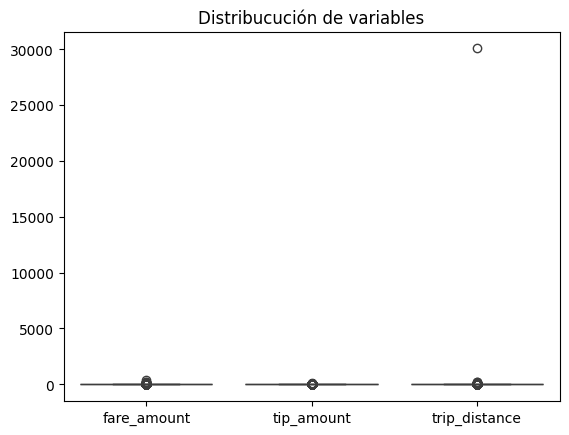

In [17]:
sns.boxplot(data=dfbox[cols])
plt.title("Distribucución de variables")
plt.show()

Eliminamos los valores atipicos superiores ya que los minimos estan bien filtrados, 2.5 $ de fare amount y 0 de tip

Procedemos a ver las velocidades de los viajes, lo realizamos para conseguir viajes de duración realista

In [2]:
dfbox16 = pd.read_csv("../data/cleaned/df1601_clean.csv", nrows=100000)
dfbox16.describe()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000
mean,1.543340,1.803270,3.127777,-73.979157,40.752672,1.021650,-73.949462,40.742063,1.431950,12.727219,0.437425,0.498170,1.530785,0.178156,3.000000e-01,15.671755
std,0.498121,1.361611,3.136411,0.019642,0.025217,0.231261,1.193148,0.658163,0.510404,9.526158,0.165551,0.030194,3.963924,1.154165,1.110229e-16,11.696160
min,1.000000,1.000000,0.010000,-74.028603,40.700035,1.000000,-75.078560,0.000000,1.000000,2.500000,0.000000,0.000000,0.000000,0.000000,3.000000e-01,3.300000
25%,1.000000,1.000000,1.160000,-73.992012,40.733959,1.000000,-73.990021,40.732555,1.000000,6.500000,0.500000,0.500000,0.000000,0.000000,3.000000e-01,8.760000
50%,2.000000,1.000000,2.100000,-73.982780,40.751114,1.000000,-73.977425,40.752045,1.000000,10.000000,0.500000,0.500000,1.000000,0.000000,3.000000e-01,12.350000
75%,2.000000,2.000000,3.960000,-73.967888,40.767587,1.000000,-73.954132,40.772781,2.000000,15.500000,0.500000,0.500000,2.260000,0.000000,3.000000e-01,18.800000
max,2.000000,8.000000,97.400000,-73.900047,40.879227,5.000000,0.000000,41.211109,4.000000,250.000000,2.000000,0.500000,998.140000,33.300000,3.000000e-01,1004.940000


In [4]:
import pandas as pd
import os

# Parámetros de limpieza
lat_min, lat_max = 40.70, 40.88
lon_min, lon_max = -74.03, -73.90
MAX_DURATION_SECONDS = 12 * 60 * 60
cols = ["fare_amount", "trip_distance", "tip_amount"]
vel_col = "velocidad_kmh"

# Asegurarse de que la carpeta de salida existe
os.makedirs("../data/cleaned", exist_ok=True)

for reader, output_path in zip(dfs, output_files):
    print(f"Procesando y limpiando: {output_path}")
    first_chunk = True

    for chunk in reader:
        chunk = chunk.dropna()
        chunk = chunk[chunk["trip_distance"] > 0]
        chunk = chunk[chunk["fare_amount"] >= 2.5]

        chunk = chunk[
            (chunk["pickup_latitude"].between(lat_min, lat_max)) &
            (chunk["pickup_longitude"].between(lon_min, lon_max))
        ]

        # Convertir a datetime
        chunk["tpep_pickup_datetime"] = pd.to_datetime(chunk["tpep_pickup_datetime"])
        chunk["tpep_dropoff_datetime"] = pd.to_datetime(chunk["tpep_dropoff_datetime"])

        # Calcular duración del viaje
        duration = (chunk["tpep_dropoff_datetime"] - chunk["tpep_pickup_datetime"]).dt.total_seconds()
        chunk = chunk[duration <= MAX_DURATION_SECONDS]
        chunk["duracion_horas"] = duration / 3600

        # Calcular velocidad en km/h
        chunk["distancia_km"] = chunk["trip_distance"] * 1.60934
        chunk[vel_col] = chunk["distancia_km"] / chunk["duracion_horas"]

        # Eliminar velocidades infinitas o NaN
        chunk = chunk.replace([float("inf"), -float("inf")], pd.NA)
        chunk = chunk.dropna(subset=[vel_col])

        # Filtro por valores categóricos razonables
        chunk = chunk[chunk["payment_type"].between(1, 2)]
        chunk = chunk[chunk["passenger_count"].between(1, 4)]
        chunk = chunk[chunk["extra"].between(0, 1)]

        # --- Outliers por IQR en columnas numéricas ---
        for col in cols + [vel_col]:
            if col in chunk.columns:
                Q1 = chunk[col].quantile(0.25)
                Q3 = chunk[col].quantile(0.75)
                IQR = Q3 - Q1
                upper_limit = Q3 + 1.5 * IQR
                lower_limit = Q1 - 1.5 * IQR
                chunk = chunk[(chunk[col] >= lower_limit) & (chunk[col] <= upper_limit)]

        # Guardar chunk limpio
        chunk.to_csv(output_path, mode='a', header=first_chunk, index=False)
        first_chunk = False

    print(f"✔ Guardado: {output_path}\n")

Procesando y limpiando: ../data/cleaned/df1501_clean.csv
✔ Guardado: ../data/cleaned/df1501_clean.csv

Procesando y limpiando: ../data/cleaned/df1601_clean.csv
✔ Guardado: ../data/cleaned/df1601_clean.csv

Procesando y limpiando: ../data/cleaned/df1602_clean.csv
✔ Guardado: ../data/cleaned/df1602_clean.csv

Procesando y limpiando: ../data/cleaned/df1603_clean.csv
✔ Guardado: ../data/cleaned/df1603_clean.csv



Comprobando que los datos estan limpios

In [6]:
dfbox16 = pd.read_csv("../data/cleaned/df1601_clean.csv", nrows=100000)
dfbox16.describe()


,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duracion_horas,distancia_km,velocidad_kmh
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.498780,1.426850,2.303041,-73.978568,40.753116,1.000750,-73.953521,40.742842,1.431610,10.302737,0.420605,0.499875,1.193050,0.022276,3.000000e-01,12.738542,0.184055,3.706376,20.583321
std,0.500001,0.758759,1.605986,0.019675,0.025060,0.051083,1.215595,0.670235,0.495303,5.114696,0.182755,0.007905,1.352456,0.433412,1.110229e-16,5.745751,0.114958,2.584577,7.623458
min,1.000000,1.000000,0.010000,-74.028603,40.700035,1.000000,-74.058372,0.000000,1.000000,2.500000,0.000000,0.000000,0.000000,0.000000,3.000000e-01,3.300000,0.000833,0.016093,0.015495
25%,1.000000,1.000000,1.090000,-73.991600,40.734627,1.000000,-73.990509,40.735271,1.000000,6.500000,0.500000,0.500000,0.000000,0.000000,3.000000e-01,8.300000,0.096944,1.754181,15.134365
50%,1.000000,1.000000,1.840000,-73.982208,40.751591,1.000000,-73.978668,40.752510,1.000000,9.000000,0.500000,0.500000,1.000000,0.000000,3.000000e-01,11.300000,0.159722,2.961186,19.706204
75%,2.000000,2.000000,3.160000,-73.967323,40.768286,1.000000,-73.957642,40.771568,2.000000,13.000000,0.500000,0.500000,2.040000,0.000000,3.000000e-01,16.000000,0.246944,5.085514,25.394480
max,2.000000,4.000000,8.640000,-73.900047,40.879227,5.000000,0.000000,40.908958,2.000000,32.500000,1.000000,0.500000,5.200000,70.000000,3.000000e-01,75.300000,4.443889,13.904698,44.844530
